In [3]:
import backtrader as bt
import backtrader.indicators as btind
import datetime as dt
import pandas as pd
import pandas_datareader as web
from pandas import Series, DataFrame
import random
from copy import deepcopy

In [4]:
class SMAC(bt.Strategy):
    """A simple moving average crossover strategy; crossing of a fast and slow moving average generates buy/sell
       signals"""
    params = {"fast": 20, "slow": 50,                  # The windows for both fast and slow moving averages
              "optim": False, "optim_fs": (20, 50)}    # Used for optimization; equivalent of fast and slow, but a tuple
                                                       # The first number in the tuple is the fast MA's window, the
                                                       # second the slow MA's window
 
    def __init__(self):
        """Initialize the strategy"""
 
        self.fastma = dict()
        self.slowma = dict()
        self.regime = dict()
 
        if self.params.optim:    # Use a tuple during optimization
            self.params.fast, self.params.slow = self.params.optim_fs    # fast and slow replaced by tuple's contents
 
        if self.params.fast > self.params.slow:
            raise ValueError(
                "A SMAC strategy cannot have the fast moving average's window be " + \
                 "greater than the slow moving average window.")
 
        for d in self.getdatanames():
 
            # The moving averages
            self.fastma[d] = btind.SimpleMovingAverage(self.getdatabyname(d),      # The symbol for the moving average
                                                       period=self.params.fast,    # Fast moving average
                                                       plotname="FastMA: " + d)
            self.slowma[d] = btind.SimpleMovingAverage(self.getdatabyname(d),      # The symbol for the moving average
                                                       period=self.params.slow,    # Slow moving average
                                                       plotname="SlowMA: " + d)
 
            # Get the regime
            self.regime[d] = self.fastma[d] - self.slowma[d]    # Positive when bullish
 
    def next(self):
        """Define what will be done in a single step, including creating and closing trades"""
        for d in self.getdatanames():    # Looping through all symbols
            pos = self.getpositionbyname(d).size or 0
            if pos == 0:    # Are we out of the market?
                # Consider the possibility of entrance
                # Notice the indexing; [0] always mens the present bar, and [-1] the bar immediately preceding
                # Thus, the condition below translates to: "If today the regime is bullish (greater than
                # 0) and yesterday the regime was not bullish"
                if self.regime[d][0] > 0 and self.regime[d][-1] <= 0:    # A buy signal
                    self.buy(data=self.getdatabyname(d))
 
            else:    # We have an open position
                if self.regime[d][0] <= 0 and self.regime[d][-1] > 0:    # A sell signal
                    self.sell(data=self.getdatabyname(d))
 
 
class PropSizer(bt.Sizer):
    """A position sizer that will buy as many stocks as necessary for a certain proportion of the portfolio
       to be committed to the position, while allowing stocks to be bought in batches (say, 100)"""
    params = {"prop": 0.1, "batch": 100}
 
    def _getsizing(self, comminfo, cash, data, isbuy):
        """Returns the proper sizing"""
 
        if isbuy:    # Buying
            target = self.broker.getvalue() * self.params.prop    # Ideal total value of the position
            price = data.close[0]
            shares_ideal = target / price    # How many shares are needed to get target
            batches = int(shares_ideal / self.params.batch)    # How many batches is this trade?
            shares = batches * self.params.batch    # The actual number of shares bought
 
            if shares * price > cash:
                return 0    # Not enough money for this trade
            else:
                return shares
 
        else:    # Selling
            return self.broker.getposition(data).size    # Clear the position
 
 
class AcctValue(bt.Observer):
    alias = ('Value',)
    lines = ('value',)
 
    plotinfo = {"plot": True, "subplot": True}
 
    def next(self):
        self.lines.value[0] = self._owner.broker.getvalue()    # Get today's account value (cash + stocks)
 
 
class AcctStats(bt.Analyzer):
    """A simple analyzer that gets the gain in the value of the account; should be self-explanatory"""
 
    def __init__(self):
        self.start_val = self.strategy.broker.get_value()
        self.end_val = None
 
    def stop(self):
        self.end_val = self.strategy.broker.get_value()
 
    def get_analysis(self):
        return {"start": self.start_val, "end": self.end_val,
                "growth": self.end_val - self.start_val, "return": self.end_val / self.start_val}

In [17]:
start = dt.datetime(2010, 1, 10)
end = dt.datetime(2016, 10, 31)
#aapl = web.DataReader('AAPL','yahoo',start,end)
# Different stocks from past posts because of different data source (no plot for NTDOY)
symbols = ["AAPL", "GOOG", "MSFT", "AMZN", "SNY", "VZ", "IBM", "HPQ", "QCOM", "NVDA"]
datafeeds = {s: web.DataReader(s, "yahoo", start, end) for s in symbols}
#for df in datafeeds.values():
    #df["OpenInterest"] = 0    # PandasData reader expects an OpenInterest column;
                              # not provided by Google and we don't use it so set to 0
    #df['Date'] = 0
 



In [ ]:
cerebro = bt.Cerebro(stdstats=False)
 
plot_symbols = ["AAPL", "GOOG", "NVDA"]
is_first = True
#plot_symbols = []
for s, df in datafeeds.items():
    data = bt.feeds.PandasData(dataname=df, name=s)
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    cerebro.adddata(data)    # Give the data to cerebro
 
cerebro.broker.setcash(1000000)
cerebro.broker.setcommission(0.02)
cerebro.addstrategy(SMAC)
cerebro.addobserver(AcctValue)
cerebro.addobservermulti(bt.observers.BuySell)    # Plots up/down arrows
cerebro.addsizer(PropSizer)
cerebro.addanalyzer(AcctStats)
 
cerebro.run()

/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/zoakes/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/zoakes/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel/k

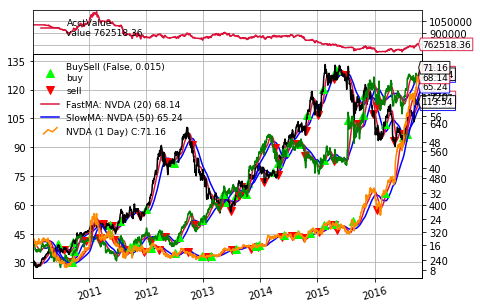

[[<matplotlib.figure.Figure at 0x1a1c29ec10>]]

In [50]:
#import matplotlib.pyplot as plt 
'''Why is this not plotting ? '''
%matplotlib inline
cerebro.plot(iplot=True, volume=False)

In [31]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import numpy as np

 
class TimeSeriesSplitImproved(TimeSeriesSplit):
    """Time Series cross-validator
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals, in train/test sets.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide `.
    Parameters
    ----------
    n_splits : int, default=3
        Number of splits. Must be at least 1.
    Examples
    --------
    >>> from sklearn.model_selection import TimeSeriesSplit
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4])
    >>> tscv = TimeSeriesSplit(n_splits=3)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(n_splits=3)
    >>> for train_index, test_index in tscv.split(X):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    >>> for train_index, test_index in tscv.split(X, fixed_length=True):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [1] TEST: [2]
    TRAIN: [2] TEST: [3]
    >>> for train_index, test_index in tscv.split(X, fixed_length=True,
    ...     train_splits=2):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [1 2] TEST: [3]
 
    Notes
    -----
    When ``fixed_length`` is ``False``, the training set has size
    ``i * train_splits * n_samples // (n_splits + 1) + n_samples %
    (n_splits + 1)`` in the ``i``th split, with a test set of size
    ``n_samples//(n_splits + 1) * test_splits``, where ``n_samples``
    is the number of samples. If fixed_length is True, replace ``i``
    in the above formulation with 1, and ignore ``n_samples %
    (n_splits + 1)`` except for the first training set. The number
    of test sets is ``n_splits + 2 - train_splits - test_splits``.
    """
 
    def split(self, X, y=None, groups=None, fixed_length=False,
              train_splits=1, test_splits=1):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like, shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like, with shape (n_samples,), optional
            Always ignored, exists for compatibility.
        fixed_length : bool, hether training sets should always have
            common length
        train_splits : positive int, for the minimum number of
            splits to include in training sets
        test_splits : positive int, for the number of splits to
            include in the test set
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        train_splits, test_splits = int(train_splits), int(test_splits)
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater than the number of samples: {1}.").format(n_folds,n_samples))
        if (n_folds - train_splits - test_splits) < 0 and test_splits > 0:
            raise ValueError(("Both train_splits and test_splits must be positive integers."))
        indices = np.arange(n_samples)
        split_size = (n_samples // n_folds)
        test_size = split_size * test_splits
        train_size = split_size * train_splits
        test_starts = range(train_size + n_samples % n_folds,
                            n_samples - (test_size - split_size),
                            split_size)
        if fixed_length:
            for i, test_start in zip(range(len(test_starts)),
                                     test_starts):
                rem = 0
                if i == 0:
                    rem = n_samples % n_folds
                yield (indices[(test_start - train_size - rem):test_start],indices[test_start:test_start + test_size])
        else:
            for test_start in test_starts:
                yield (indices[:test_start],indices[test_start:test_start + test_size])

In [32]:
tscv = TimeSeriesSplitImproved(10)
split = tscv.split(datafeeds["AAPL"], fixed_length=True, train_splits=2)

In [33]:
walk_forward_results = list()
# Be prepared: this will take a while
for train, test in split:
    # TRAINING
 
    # Generate random combinations of fast and slow window lengths to test
    windowset = set()    # Use a set to avoid duplicates
    while len(windowset) < 40:
        f = random.randint(1, 10) * 5
        s = random.randint(1, 10) * 10
        if f > s:    # Cannot have the fast moving average have a longer window than the slow, so swap
            f, s = s, f
        elif f == s:    # Cannot be equal, so do nothing, discarding results
            continue
        windowset.add((f, s))
 
    windows = list(windowset)
 
    trainer = bt.Cerebro(stdstats=False, maxcpus=1)
    trainer.broker.set_cash(1000000)
    trainer.broker.setcommission(0.02)
    trainer.addanalyzer(AcctStats)
    trainer.addsizer(PropSizer)
    tester = deepcopy(trainer)
 
    trainer.optstrategy(SMAC, optim=True,    # Optimize the strategy (use optim variant of SMAC)...
                          optim_fs=windows)    # ... over all possible combinations of windows
    for s, df in datafeeds.items():
        data = bt.feeds.PandasData(dataname=df.iloc[train], name=s)    # Add a subset of data
                                                                       # to the object that
                                                                       # corresponds to training
        trainer.adddata(data)
    res = trainer.run()
    # Get optimal combination
    opt_res = DataFrame({r[0].params.optim_fs: r[0].analyzers.acctstats.get_analysis() for r in res}
                       ).T.loc[:, "return"].sort_values(ascending=False).index[0]
 
    # TESTING
    tester.addstrategy(SMAC, optim=True, optim_fs=opt_res)    # Test with optimal combination
    for s, df in datafeeds.items():
        data = bt.feeds.PandasData(dataname=df.iloc[test], name=s)    # Add a subset of data
                                                                       # to the object that
                                                                       # corresponds to testing
        tester.adddata(data)
 
    res = tester.run()
    res_dict = res[0].analyzers.acctstats.get_analysis()
    res_dict["fast"], res_dict["slow"] = opt_res
    res_dict["start_date"] = datafeeds["AAPL"].iloc[test[0]].name
    res_dict["end_date"] = datafeeds["AAPL"].iloc[test[-1]].name
    walk_forward_results.append(res_dict)

Exception ignored in: <function Comm.__del__ at 0x108ce59e0>
Traceback (most recent call last):
  File "/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 76, in __del__
    self.close()
  File "/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 116, in close
    self.kernel.comm_manager.unregister_comm(self)
  File "/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel/comm/manager.py", line 56, in unregister_comm
    comm = self.comms.pop(comm.comm_id)
KeyError: ('d4aaf173566b4fae93e5a811497d39aa',)


In [34]:
wfdf = DataFrame(walk_forward_results)
wfdf

,start,end,growth,return,fast,slow,start_date,end_date
0,1000000,9.590194e+05,-40980.593208,0.959019,30,90,2011-04-18,2011-11-25
1,1000000,1.000000e+06,0.000000,1.000000,45,100,2011-11-28,2012-07-10
2,1000000,1.013602e+06,13601.983538,1.013602,30,100,2012-07-11,2013-02-22
3,1000000,9.995360e+05,-464.045189,0.999536,15,70,2013-02-25,2013-10-03
4,1000000,9.899827e+05,-10017.274498,0.989983,15,100,2013-10-04,2014-05-16
5,1000000,9.463096e+05,-53690.400074,0.946310,25,70,2014-05-19,2014-12-26
6,1000000,9.731279e+05,-26872.114738,0.973128,35,70,2014-12-29,2015-08-10
7,1000000,1.002428e+06,2427.701786,1.002428,25,100,2015-08-11,2016-03-22
8,1000000,9.965047e+05,-3495.287384,0.996505,50,100,2016-03-23,2016-10-31


In [35]:
'''Another example -- hoping for a PLOT!'''

'Another example -- hoping for a PLOT!'

In [37]:
class SMACWalkForward(bt.Strategy):
    """The SMAC strategy but in a walk-forward analysis context"""
    params = {"start_dates": None,    # Starting days for trading periods (a list)
              "end_dates": None,      # Ending day for trading periods (a list)
              "fast": None,           # List of fast moving average windows, corresponding to start dates (a list)
              "slow": None}           # Like fast, but for slow moving average window (a list)
    # All the above lists must be of the same length, and they all line up
 
    def __init__(self):
        """Initialize the strategy"""
 
        self.fastma = dict()
        self.slowma = dict()
        self.regime = dict()
 
        self.date_combos = [c for c in zip(self.p.start_dates, self.p.end_dates)]
 
        # Error checking
        if type(self.p.start_dates) is not list or type(self.p.end_dates) is not list or \
           type(self.p.fast) is not list or type(self.p.slow) is not list:
            raise ValueError("Must past lists filled with numbers to params start_dates, end_dates, fast, slow.")
        elif len(self.p.start_dates) != len(self.p.end_dates) or \
            len(self.p.fast) != len(self.p.start_dates) or len(self.p.slow) != len(self.p.start_dates):
            raise ValueError("All lists passed to params must have same length.")
 
        for d in self.getdatanames():
            self.fastma[d] = dict()
            self.slowma[d] = dict()
            self.regime[d] = dict()
 
            # Additional indexing, allowing for differing start/end dates
            for sd, ed, f, s in zip(self.p.start_dates, self.p.end_dates, self.p.fast, self.p.slow):
                # More error checking
                if type(f) is not int or type(s) is not int:
                    raise ValueError("Must include only integers in fast, slow.")
                elif f > s:
                    raise ValueError("Elements in fast cannot exceed elements in slow.")
                elif f <= 0 or s <= 0:
                    raise ValueError("Moving average windows must be positive.")
 
                if type(sd) is not dt.date or type(ed) is not dt.date:
                    raise ValueError("Only datetime dates allowed in start_dates, end_dates.")
                elif ed - sd < dt.timedelta(0):
                    raise ValueError("Start dates must always be before end dates.")
 
                # The moving averages
                # Notice that different moving averages are obtained for different combinations of
                # start/end dates
                self.fastma[d][(sd, ed)] = btind.SimpleMovingAverage(self.getdatabyname(d),
                                                           period=f,
                                                           plot=False)
                self.slowma[d][(sd, ed)] = btind.SimpleMovingAverage(self.getdatabyname(d),
                                                           period=s,
                                                           plot=False)
 
                # Get the regime
                self.regime[d][(sd, ed)] = self.fastma[d][(sd, ed)] - self.slowma[d][(sd, ed)]
                # In the future, use the backtrader indicator btind.CrossOver()
 
    def next(self):
        """Define what will be done in a single step, including creating and closing trades"""
 
        # Determine which set of moving averages to use
        curdate = self.datetime.date(0)
        dtidx = None    # Will be index
        # Determine which period (if any) we are in
        for sd, ed in self.date_combos:
            # Debug output
            #print('{}: {} < {}: {}, {} < {}: {}'.format(
            #    len(self), sd, curdate, (sd <= curdate), curdate, ed, (curdate <= ed)))
            if sd <= curdate and curdate <= ed:
                dtidx = (sd, ed)
        # Debug output
        #print('{}: the dtixdx is {}, and curdate is {};'.format(len(self), dtidx, curdate))
        for d in self.getdatanames():    # Looping through all symbols
            pos = self.getpositionbyname(d).size or 0
            if dtidx is None:    # Not in any window
                break            # Don't engage in trades
            if pos == 0:    # Are we out of the market?
                # Consider the possibility of entrance
                # Notice the indexing; [0] always mens the present bar, and [-1] the bar immediately preceding
                # Thus, the condition below translates to: "If today the regime is bullish (greater than
                # 0) and yesterday the regime was not bullish"
                if self.regime[d][dtidx][0] > 0 and self.regime[d][dtidx][-1] <= 0:    # A buy signal
                    self.buy(data=self.getdatabyname(d))
 
            else:    # We have an open position
                if self.regime[d][dtidx][0] <= 0 and self.regime[d][dtidx][-1] > 0:    # A sell signal
                    self.sell(data=self.getdatabyname(d))

In [38]:
cerebro_wf = bt.Cerebro(stdstats=False)
 
plot_symbols = ["AAPL", "GOOG", "NVDA"]
is_first = True
#plot_symbols = []
for s, df in datafeeds.items():
    data = bt.feeds.PandasData(dataname=df, name=s)
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    cerebro_wf.adddata(data)    # Give the data to cerebro
 
cerebro_wf.broker.setcash(1000000)
cerebro_wf.broker.setcommission(0.02)
cerebro_wf.addstrategy(SMACWalkForward,
                       # Give the results of the above optimization to SMACWalkForward (NOT OPTIONAL)
                       fast=[int(f) for f in wfdf.fast],
                       slow=[int(s) for s in wfdf.slow],
                       start_dates=[sd.date() for sd in wfdf.start_date],
                       end_dates=[ed.date() for ed in wfdf.end_date])
cerebro_wf.addobserver(AcctValue)
cerebro_wf.addobservermulti(bt.observers.BuySell)    # Plots up/down arrows
cerebro_wf.addsizer(PropSizer)
cerebro_wf.addanalyzer(AcctStats)
 
cerebro_wf.run()

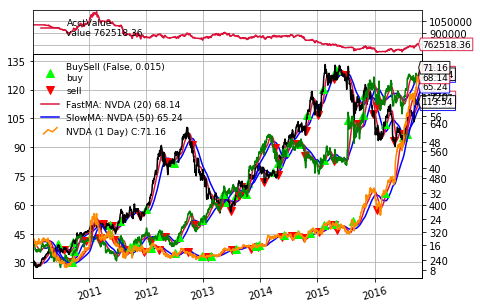

[[<matplotlib.figure.Figure at 0x1a1bc72410>]]

In [48]:


import backtrader.plot
import matplotlib
#matplotlib.use('QT5Agg')
%matplotlib inline

# Your running code

cerebro.plot(height=30,width=30,iplot= False)

In [41]:
cerebro_wf.broker.get_value()

980093.4782886505